In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import classification_report,confusion_matrix,multilabel_confusion_matrix
import transformers
from PIL import Image
from efficientnet_pytorch import EfficientNet
from torchvision.io import read_image, ImageReadMode
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [2]:
from mmar.custom.pylon.trainer.start import *
from mmar.custom.pylon.utils.pretrain import *
from mmar.custom.pylon.model.common import *
from mmar.custom.pylon.pylon import PylonConfig

In [3]:
from albumentations import HorizontalFlip, Rotate, RandomBrightnessContrast, Flip, Compose, RandomResizedCrop
from typing import List, Optional, Dict, Generator, NamedTuple, Any, Tuple, Union, Mapping

In [4]:
epochs = 50

labels_col = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Pneumothorax', 'Edema']
classes = 5 # number of findings
image_w = 256
image_h = 256
batch_size = 32
n_labels = len(labels_col)

In [5]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def dicom2array(path, voi_lut=True, fix_monochrome=True):
    """Convert DICOM file to numy array
    
    Args: 
        path (str): Path to the DICOM file to be converted
        voi_lut (bool): Whether or not VOI LUT is available
        fix_monochrome (bool): Whether or not to apply MONOCHROME fix
        
    Returns:
        Numpy array of the respective DICOM file
    """
    
    # Use the pydicom library to read the DICOM file
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # Depending on this value, X-ray may look inverted - fix that
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    # Normalize the image array
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data

In [6]:
class XRayDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, target_transform=None):
      self.img_files = df['Image'].tolist()
      self.img_labels = df[labels_col].values
      self.transform = transform
      self.target_transform = target_transform
      self.image_dir = image_dir

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      img_path = os.path.join(self.image_dir, self.img_files[idx])
      if '.dcm' in self.img_files[idx]:
        image = dicom2array(img_path)
        image = torch.tensor(image)/255
        image = image.unsqueeze(0)
      else:
        image = read_image(img_path, mode=ImageReadMode.GRAY)/255

      label = self.img_labels[idx]
      if self.transform:
          image = image[0].numpy()
          aug = self.transform(image=image)
          image = torch.from_numpy(aug["image"])
          image = image.unsqueeze(0)
      image = image.unsqueeze(0)
      image = F.interpolate(image, size=image_w)
      image = image[0]
      # image = image.expand(3, -1, -1)
      return image, label

In [7]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [8]:
def augment(p=0.5):
    return Compose([
        RandomResizedCrop(image_h,image_w,scale=(0.7, 1.0), p=1.0),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(0.5,0.5,p=0.5),
        Rotate(90, border_mode=0, p=0.5),
    ], p=p)
augmentation = augment()

In [9]:
site_name = 'nih' # edit
sites = ['chula', 'nih', 'padchest', 'mimic']
col_list = ['Image', 'Atelectasis', 'Cardiomegaly', 'Edema', 'Effusion', 'Pneumothorax']
labels_col = col_list[1:]

data_path = '/workspace/nvflare/fl-nvflare/data/'
site_path = data_path + 'data_' + site_name
IMAGE_PATH = site_path + '/image'

# train and val from 1 site
train = pd.read_csv(site_path + '/train_' + site_name + '.csv')
val = pd.read_csv(site_path + '/val_' + site_name + '.csv')
# test = pd.read_csv(site_path + '/test_' + site_name + '.csv')

# test from all sites
# test = pd.DataFrame(columns=col_list)
# for s in sites:   
#     df = pd.read_csv(data_path + s + '/test_' + s + '.csv')
#     df['Image'] = df['Image'].apply(lambda x: data_path + s + '/image/' + x)
#     test = pd.concat([test,df],axis=0)
# test = test.sample(frac=1).reset_index(drop=True)
# test

In [10]:
train_dataset = XRayDataset(train, IMAGE_PATH, transform=augmentation)
valid_dataset = XRayDataset(val, IMAGE_PATH)
# test_dataset = XRayDataset(test, IMAGE_PATH)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
DEVICE = "cuda"

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        net_conf = PylonConfig(
            n_in=1,
            n_out=n_labels,
            up_type='2layer',
            pretrain_conf=PretrainConfig(
                pretrain_name='nih',
                path='/workspace/nvflare/fl-nvflare/pylon,nih,256.pkl',
            ),
            freeze='enc',
        )
        self.image_model = net_conf.make_model()
    
    def forward(self,image):
        image_output = self.image_model(image)
        return image_output

In [14]:
model = Net()
model.to(DEVICE)

err: _IncompatibleKeys(missing_keys=['net.segmentation_head.0.weight', 'net.segmentation_head.0.bias'], unexpected_keys=[])


Net(
  (image_model): Pylon(
    (net): PylonCore(
      (encoder): ResNetEncoder(
        (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)  

In [16]:
device = 'cuda'

In [17]:
loss_arr = []
val_loss_arr = []
min_loss = 10

early_stopping = EarlyStopping(patience=10)
end_epoch = 0

for epoch in range(epochs):
  print(f'Epoch {epoch}/{epochs-1}')

  # train
  running_loss = 0.0
  s = time.time()
  n_total_steps = len(train_dataloader)
  model.train()
  for i, (images, labels) in enumerate(train_dataloader):  
    images = images.to(device)
    labels = labels.to(device)
    # forward
    # track history if only in train
    with torch.set_grad_enabled(True):
      outputs = model(images)
      outputs = outputs.pred
      # print(outputs)
      loss = criterion(outputs, labels.float())
  
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * images.size(0)
      if (i+1) % 50 == 0:
          print (f'[Train] Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, time: {(time.time()-s):.4f}s')
          s = time.time()
  epoch_loss = running_loss / len(train_dataset)
  loss_arr.append(epoch_loss)
  print (f'[Train] Epoch {epoch}/{epochs-1}, Loss: {epoch_loss:.4f}')

  # eval
  running_loss = 0.0
  s = time.time()
  n_total_steps = len(valid_dataloader)
  model.eval()
  for i, (images, labels) in enumerate(valid_dataloader):  
    images = images.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
      outputs = model(images)
      outputs = outputs.pred
      loss = criterion(outputs, labels.float())
      running_loss += loss.item() * images.size(0)
  
  epoch_loss = running_loss / len(valid_dataset)
  val_loss_arr.append(epoch_loss)
  # save model with min loss
  if min_loss > epoch_loss:
    min_loss = epoch_loss
    torch.save(model.state_dict(), site_path + '/model_best_nih.pth') 
    print(f'Save model_best, Loss: {epoch_loss:.4f}')

  early_stopping(epoch_loss)
  if early_stopping.early_stop:
    print(f"Early stopping at val_loss : {epoch_loss}")
    end_epoch = epoch
    break

  print (f'[Eval] Epoch {epoch}/{epochs-1}, Loss: {epoch_loss:.4f}')
  print('-' * 10)
  end_epoch = epoch

Epoch 0/49
[Train] Step [50/156], Loss: 2.3804, time: 43.2931s
[Train] Step [100/156], Loss: 1.3912, time: 40.3766s
[Train] Step [150/156], Loss: 1.0129, time: 39.9900s
[Train] Epoch 0/49, Loss: 2.1514
Save model_best, Loss: 0.9272
[Eval] Epoch 0/49, Loss: 0.9272
----------
Epoch 1/49
[Train] Step [50/156], Loss: 0.6640, time: 39.2003s
[Train] Step [100/156], Loss: 0.4884, time: 39.2703s
[Train] Step [150/156], Loss: 0.3798, time: 40.1508s
[Train] Epoch 1/49, Loss: 0.6075
Save model_best, Loss: 0.3970
[Eval] Epoch 1/49, Loss: 0.3970
----------
Epoch 2/49
[Train] Step [50/156], Loss: 0.3306, time: 39.4084s
[Train] Step [100/156], Loss: 0.2552, time: 40.3635s
[Train] Step [150/156], Loss: 0.3610, time: 39.5869s
[Train] Epoch 2/49, Loss: 0.3312
Save model_best, Loss: 0.2724
[Eval] Epoch 2/49, Loss: 0.2724
----------
Epoch 3/49
[Train] Step [50/156], Loss: 0.2695, time: 39.7408s
[Train] Step [100/156], Loss: 0.2416, time: 39.3476s
[Train] Step [150/156], Loss: 0.1993, time: 40.8159s
[Train

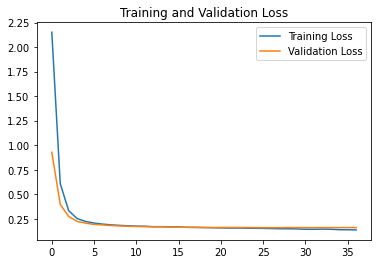

In [18]:
plt.plot(range(end_epoch+1), loss_arr, label='Training Loss')
plt.plot(range(end_epoch+1), val_loss_arr, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('nih_loss.png')
plt.show()